In [8]:
import csv
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf

from module.generator import ImageGenerator, ImageResize, ImageRotate, ImageIntensity, ImageRemoveZeros, ImageAddNoise, StretchContrast
from mnist import MNIST

from typing import Dict, Any

In [9]:
mnist = MNIST("./mnist/", return_type="numpy")
images, labels = mnist.load_training()
images = images.reshape(-1, 28, 28).astype(np.uint8)

generator = ImageGenerator(images, labels)
generator.add_layer(ImageRemoveZeros())
generator.add_layer(ImageRotate(-30, 30))
generator.add_layer(ImageResize(6, 12))
generator.add_layer(StretchContrast())

In [10]:
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = "\\usepackage{polski}"
plt.rcParams["figure.figsize"] = (10,3)
plt.rcParams["figure.autolayout"] = False
plt.rcParams["savefig.pad_inches"] = 0.01
plt.rcParams["axes.axisbelow"] = True
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "Helvetica"

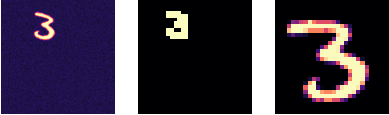

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(5, 5))
image1, label1 = generator.generate_single_image(12, n=1)
ax[0].imshow(image1[0], cmap="magma")
ax[1].imshow(label1[0], cmap="magma")
ax[2].imshow(images[12], cmap="magma")

ax[0].axis("off")
ax[1].axis("off")
ax[2].axis("off")

plt.savefig("sprawko/figures/imagelabel.pdf", bbox_inches="tight")

In [12]:
def get_table(data: list) -> str:
    ret = ""
    rows = len(data)
    columns = len(data[0])
    ret += f"""\\begin{{tabular}}{{|{"|".join(['c']*columns)}|}}
\t\\hline
"""
    for row in data:
        ret += "\t"
        ret += " &\t".join([str(i) for i in row])
        ret += " \\nl\n"

    ret += """\\end{tabular}"""
    return ret

def save_table(filename: str, data: list):
    with open(filename, "w") as file:
        file.write(get_table(data))

In [13]:
data: Dict[str, Any] = {}

for dir in os.listdir("output/"):
    if dir == "own_new":
        continue
    data[dir] = pd.read_csv(f"output/{dir}/log/loss.csv")

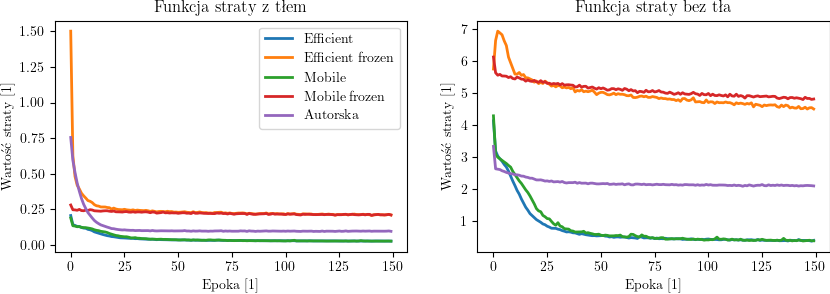

In [14]:
_min = []
_min_no = []
names = []

fig, ax = plt.subplots(1, 2)
for name in data.keys():
    if name != "own":
        new_name = " ".join(name.split("_")).capitalize()
    else:
        new_name = "Autorska"
    names.append(new_name)
    ax[0].plot(data[name].loss.to_numpy()[:150], linewidth=2, label=new_name)
    ax[1].plot(data[name].loss_no_background.to_numpy()[:150], linewidth=2, label=new_name)
    _min.append(np.min(data[name].loss.to_numpy()[:150]))
    _min_no.append(np.min(data[name].loss_no_background.to_numpy()[:150]))

ax[0].legend()
ax[0].set_title("Funkcja straty z tłem")
ax[0].set_xlabel("Epoka [1]")
ax[0].set_ylabel("Wartość straty [1]")

ax[1].set_title("Funkcja straty bez tła")
ax[1].set_xlabel("Epoka [1]")
ax[1].set_ylabel("Wartość straty [1]")
fig.savefig("sprawko/figures/loss.pdf", bbox_inches="tight")

In [15]:
table = []
table.append(["", *names])
table.append(["$\\min\\emph{loss}$", *[round(i, 5) for i in _min]])
table.append(["$\\min\\emph{loss}_{background}$", *[round(i, 5) for i in _min_no]])

save_table("sprawko/tables/loss_min.tex", table)

In [20]:
def get_model_summary(idx, model, name):
    image, _ = generator.generate_single_image(idx, n=1)
    prediction = model.predict(image, verbose=False)
    fig, ax = plt.subplots(constrained_layout=True, figsize=(10, 4))
    ax.axis("off")
    axd = fig.subplot_mosaic("MM01234;MM56789")
    axd["M"].imshow(image[0], cmap="magma")
    axd["M"].axis("off")
    axd["M"].set_title("Dane wejściowe")

    for i in range(10):
        axd[str(i)].imshow(prediction[0, :, ..., i+1], cmap="magma", vmin=0, vmax=1)
        axd[str(i)].axis("off")
        axd[str(i)].set_title(f"Warstwa cyfry {i}")

    fig.suptitle(name, fontsize=16)
    return fig

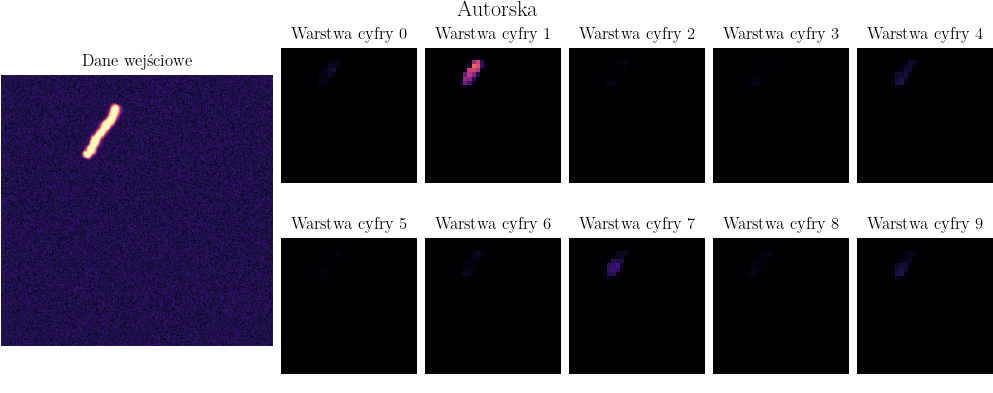

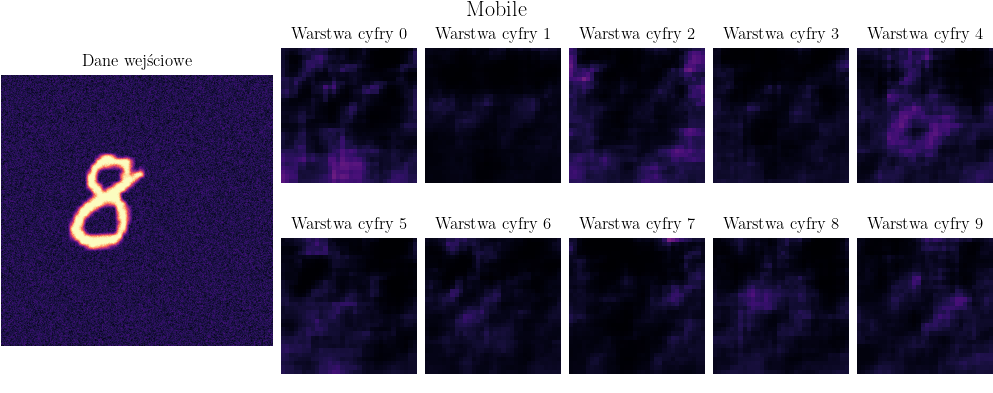

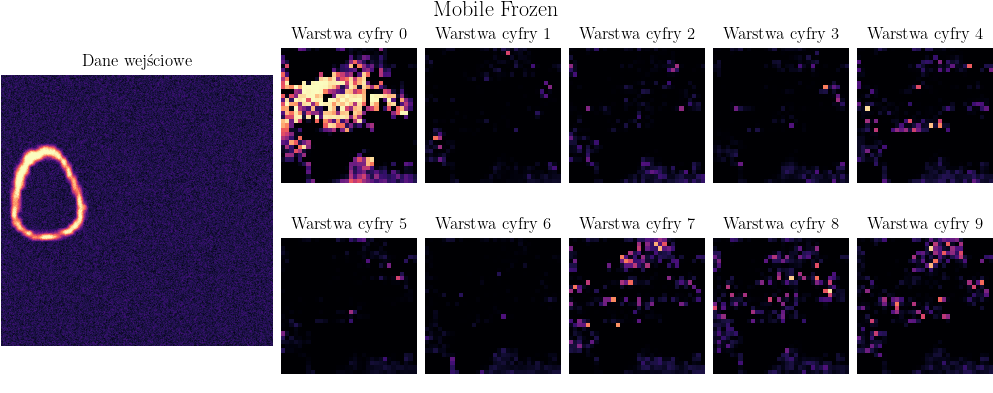

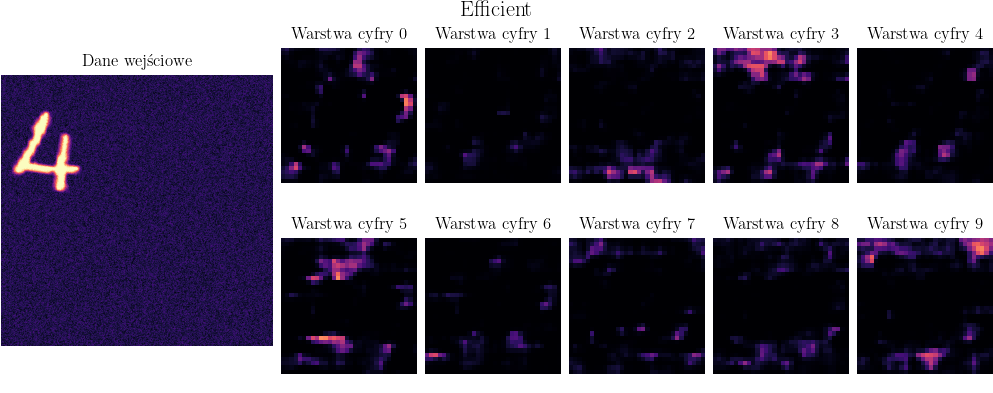

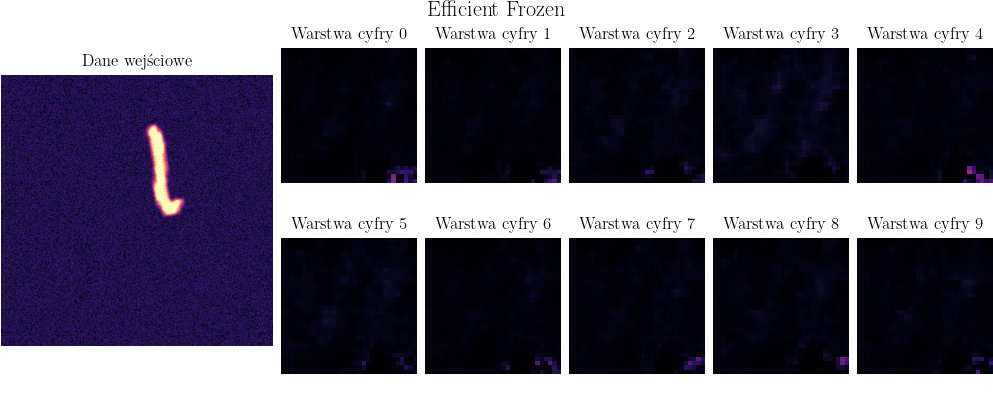

In [22]:
generator.reset()
from module.model import model
model.load_weights("output/own/model/150")
x = get_model_summary(1044, model, "Autorska")
x.savefig("sprawko/figures/own.pdf", bbox_inches="tight")

from module.mobilenet import model
model.load_weights("output/mobile/model/150")
x = get_model_summary(1045, model, "Mobile")
x.savefig("sprawko/figures/mobile.pdf", bbox_inches="tight")

model.load_weights("output/mobile_frozen/model/150")
x = get_model_summary(1046, model, "Mobile Frozen")
x.savefig("sprawko/figures/mobile_frozen.pdf", bbox_inches="tight")

from module.efficientnet import model
model.load_weights("output/efficient/model/150")
x = get_model_summary(1050, model, "Efficient")
x.savefig("sprawko/figures/efficient.pdf", bbox_inches="tight")

model.load_weights("output/efficient_frozen/model/150")
x = get_model_summary(1052, model, "Efficient Frozen")
x.savefig("sprawko/figures/efficient_frozen.pdf", bbox_inches="tight")